<a href="https://colab.research.google.com/github/sjamillah/Air_Quality_Forecasting_Model/blob/main/air_quality_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing PM2.5 Air Pollution Forecasting using LSTM Neural Networks

### This project applies Recurrent Neural Networks (RNNs) and Long Short-Term Memory
- ### (LSTM) models to solve a real-world problem: forecasting air pollution levels in Beijing.
- ### Target: Achieve RMSE < 4000 for PM2.5 concentration predictions using historical air quality and weather data.




## 1. ENVIRONMENT SETUP AND LIBRARY IMPORTS
### Setting up the deep learning environment for air pollution forecasting
### Installing and importing all necessary libraries for RNN/LSTM implementation

In [1]:
!pip install tensorflow

### Import essential libraries for data manipulation, visualization, and modeling

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.dates as mdates

## 2. DATA LOADING AND INITIALIZATION
### Loading historical Beijing PM2.5 and weather data for time series analysis
### Setting up proper datetime indexing for sequential data processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Time_Series_Forecasting_Assignment 1_Data/train.csv', header=0)
test_df = pd.read_csv('/content/drive/MyDrive/Time_Series_Forecasting_Assignment 1_Data/test.csv', header=0)

In [5]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

train_df.set_index('datetime', inplace=True)
test_df.set_index('datetime', inplace=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Training data columns: {train_df.columns.tolist()}")

Training data shape: (30676, 11)
Testing data shape: (13148, 10)
Training data columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


## 3. EXPLORATORY DATA ANALYSIS AND VISUALIZATION

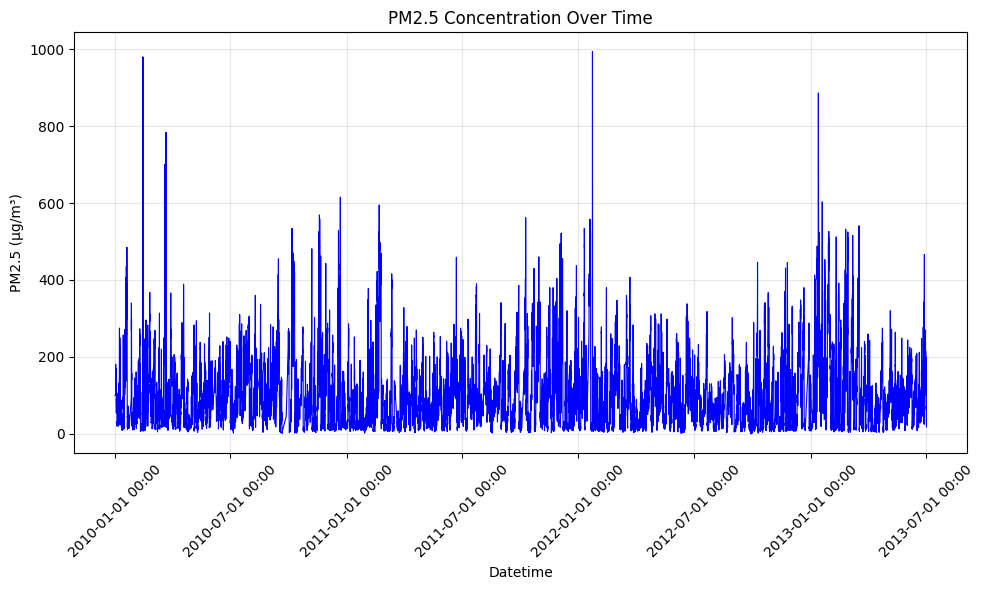

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['pm2.5'], color='blue', linewidth=0.8)
plt.xlabel('Datetime')
plt.ylabel('PM2.5 (μg/m³)')
plt.title('PM2.5 Concentration Over Time')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

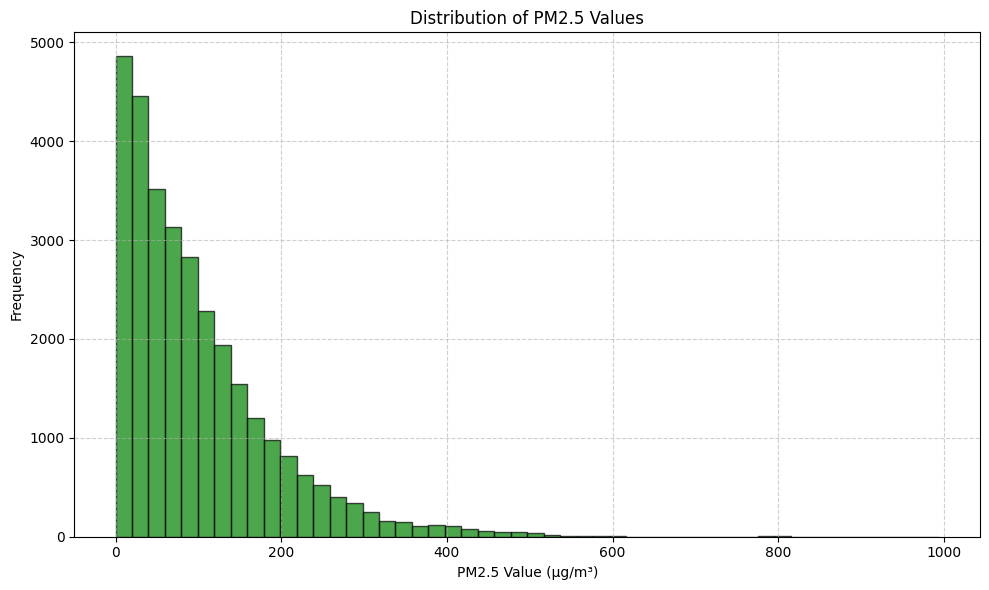

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['pm2.5'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('PM2.5 Value (μg/m³)')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 Values')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

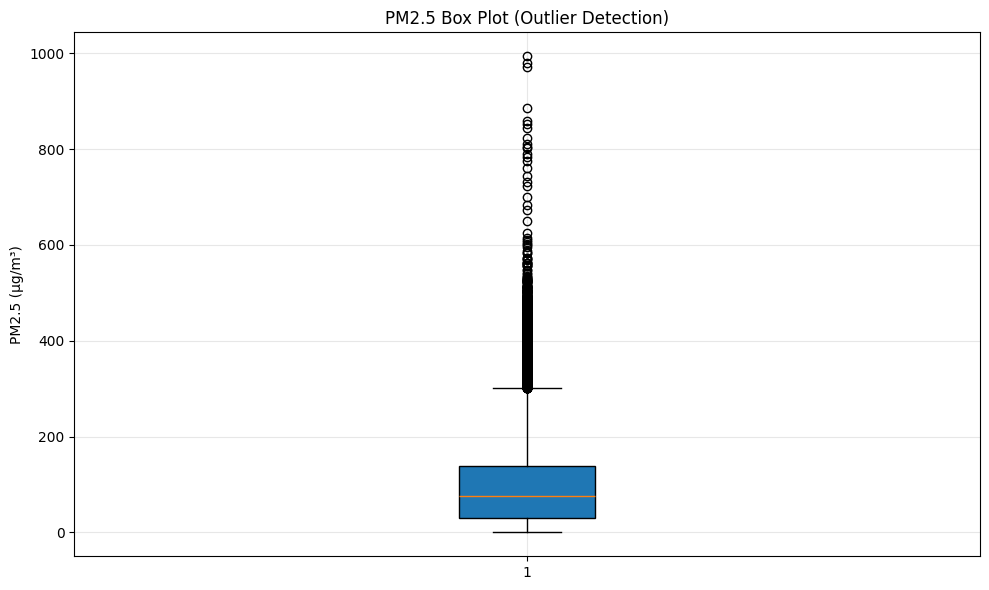

In [29]:
plt.figure(figsize=(10, 6))
plt.boxplot(train_df['pm2.5'].dropna(), patch_artist=True)
plt.ylabel('PM2.5 (μg/m³)')
plt.title('PM2.5 Box Plot (Outlier Detection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

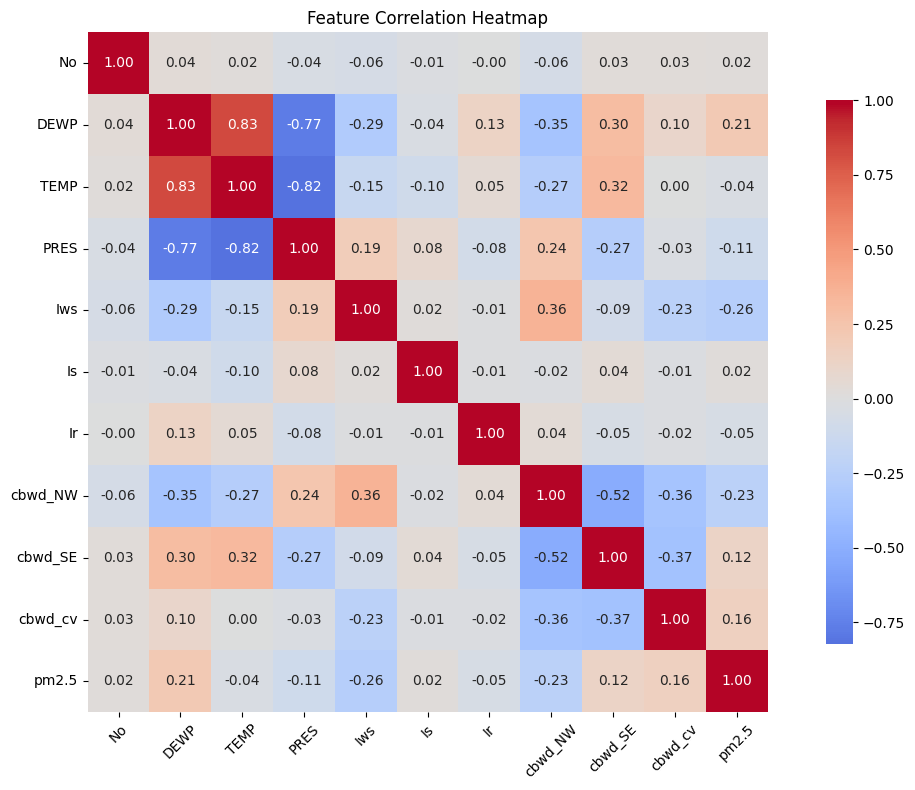

In [32]:
plt.figure(figsize=(12, 8))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. SEQUENTIAL DATA PREPROCESSING FOR RNN/LSTM
- ### Cleaning and preparing time series data for recurrent neural network training
- ### Handling missing values with time-aware interpolation methods

In [10]:
train_df = train_df.interpolate(method='time')
test_df = test_df.interpolate(method='time')

train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

print(f"Training data: {train_df.isnull().sum().sum()}")
print(f"Testing data: {test_df.isnull().sum().sum()}")

Training data: 0
Testing data: 0


## 5. TIME SERIES SEQUENCE CREATION FOR LSTM INPUT
- ### Converting raw data into sequential patterns for LSTM training
- ### Creating sliding windows to capture temporal dependencies in PM2.5 data

In [11]:
if 'No' in train_df.columns:
    features = train_df.drop(columns=['pm2.5', 'No'])
else:
    features = train_df.drop(columns=['pm2.5'])

target = train_df['pm2.5']

In [12]:
lookback = 96

def create_sequences(data, target, lookback):
    """
    Create sequences for time series forecasting
    Args:
        data: DataFrame with features
        target: Series with target values
        lookback: Number of timesteps to look back
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

In [13]:
X_train, y_train = create_sequences(features, target, lookback)

print(f"Features shape: {features.shape}")
print(f"Original training data shape: {train_df.shape}")
print(f"Sequence X_train shape: {X_train.shape}")
print(f"Sequence y_train shape: {y_train.shape}")

Features shape: (30676, 9)
Original training data shape: (30676, 11)
Sequence X_train shape: (30580, 96, 9)
Sequence y_train shape: (30580,)


## 6. DATA NORMALIZATION FOR OPTIMAL RNN TRAINING

- ### Scaling features and targets to improve LSTM convergence and stability
- ### Applying MinMax scaling to ensure all variables are in comparable ranges

In [14]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

## 7. TRAINING-VALIDATION SPLIT FOR MODEL EVALUATION

- ### Splitting sequential data while preserving temporal order
- ### Creating validation set to monitor model performance and prevent overfitting

In [15]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

print(f"Training set shape: X={X_tr.shape}, y={y_tr.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")

Training set shape: X=(24464, 96, 9), y=(24464,)
Validation set shape: X=(6116, 96, 9), y=(6116,)


## 8. DEEP LSTM ARCHITECTURE DESIGN FOR PM2.5 FORECASTING

- ### Building a multi-layer LSTM network optimized for air pollution prediction
- ### Implementing stacked LSTM layers with regularization to achieve RMSE < 4000

In [16]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(lookback, X_train.shape[2]), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,465 (525.25 KB)

 Trainable params: 134,017 (523.50 KB)

 Non-trainable params: 448 (1.75 KB)

## 10. LSTM MODEL TRAINING PROCESS
- ### Training the recurrent neural network on Beijing PM2.5 historical data
- ### Fine-tuning hyperparameters to achieve target RMSE performance

In [17]:
history = model.fit(
    X_tr, y_tr,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 158s 391ms/step - loss: 0.8627 - root_mean_squared_error: 0.7894 - val_loss: 0.3754 - val_root_mean_squared_error: 0.1563 - learning_rate: 5.0000e-04
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 199s 383ms/step - loss: 0.4149 - root_mean_squared_error: 0.2578 - val_loss: 0.2673 - val_root_mean_squared_error: 0.0980 - learning_rate: 5.0000e-04
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 193s 360ms/step - loss: 0.2695 - root_mean_squared_error: 0.1377 - val_loss: 0.2043 - val_root_mean_squared_error: 0.0848 - learning_rate: 5.0000e-04
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 139s 362ms/step - loss: 0.1976 - root_mean_squared_error: 0.0981 - val_loss: 0.1638 - val_root_mean_squared_error: 0.0957 - learning_rate: 5.0000e-04
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - loss: 0.1524 - root_mean_squared_error: 0.0874 - val_loss: 0.1228 - val_root_mean_squared_error: 0.0807 - learning_rate: 5.0000e-04
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 154s

## 11. MODEL PERFORMANCE EVALUATION AND VALIDATION
- ### Assessing LSTM prediction accuracy using RMSE, MAE, and R² metrics
- ### Validating model performance against the target RMSE < 4000 threshold

In [18]:
y_pred = model.predict(X_val)
y_pred = scaler_y.inverse_transform(y_pred)
y_val_inverse = scaler_y.inverse_transform(y_val.reshape(-1, 1))
val_rmse = np.sqrt(mean_squared_error(y_val_inverse, y_pred))

print("Validation RMSE:", val_rmse)

192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step
Validation RMSE: 48.35024857483464


In [19]:
train_predictions = model.predict(X_tr)
train_predictions = scaler_y.inverse_transform(train_predictions)
train_loss = np.mean((scaler_y.inverse_transform(y_tr.reshape(-1, 1)).flatten() - train_predictions.flatten())**2)
train_rmse = np.sqrt(train_loss)

print(f'Training MSE: {train_loss:.4f}')
print(f'Training RMSE: {train_rmse:.4f}')

765/765 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step
Training MSE: 2498.3689
Training RMSE: 49.9837


## 12. TRAINING ANALYSIS AND PERFORMANCE VISUALIZATION


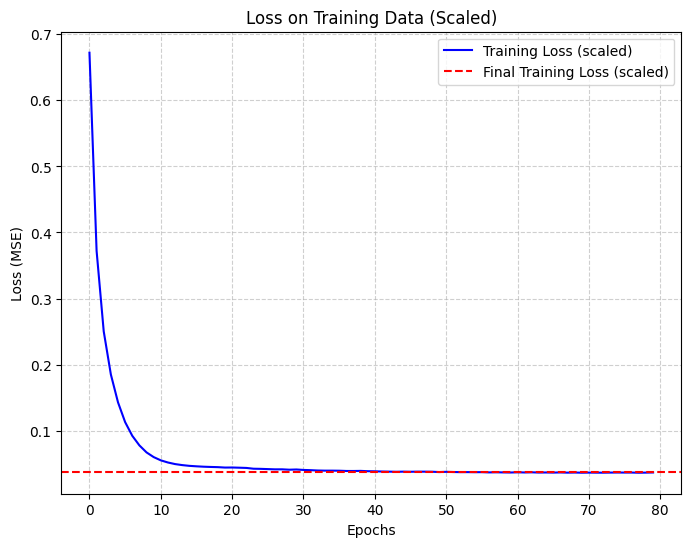

In [20]:
train_loss_scaled = history.history['loss'][-1]
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss (scaled)', color='blue')
plt.axhline(y=train_loss_scaled, color='red', linestyle='--', label='Final Training Loss (scaled)')
plt.title('Loss on Training Data (Scaled)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 13. TEST DATA SEQUENCE PREPARATION

In [21]:
print("Test dataframe shape:", test_df.shape)

if 'No' in test_df.columns:
    X_test_features = test_df.drop(['No'], axis=1)
else:
    X_test_features = test_df.copy()

Test dataframe shape: (13148, 10)


In [22]:
padding = pd.DataFrame([X_test_features.iloc[0].values] * (lookback - 1), columns=X_test_features.columns)
X_test_features_padded = pd.concat([padding, X_test_features], ignore_index=True)

In [23]:
X_test = []
for i in range(len(X_test_features_padded) - lookback + 1):
    X_test.append(X_test_features_padded.iloc[i:i + lookback].values)

X_test = np.array(X_test)
print(f"Final X_test shape: {X_test.shape}")

Final X_test shape: (13148, 96, 9)


In [24]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

## 14. FINAL PM2.5 PREDICTIONS AND COMPETITION SUBMISSION

In [25]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

predictions = np.nan_to_num(predictions)
predictions = np.round(predictions).astype(int)

411/411 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step


In [26]:
submission_indices = test_df.index[:len(predictions)]

submission = pd.DataFrame({
    'row ID': pd.to_datetime(submission_indices).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

submission = submission.sort_values(by='row ID')

submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)